<a href="https://colab.research.google.com/github/mzaoualim/us_gas_price/blob/main/notebooks/step_by_step_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 29.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import autogluon.core as ag

In [ ]:
# post ideas

# the genius of adapting LLM to TS forecasting! >> [treating the “time series” simply as a sequence.]
# > what are the fundamental differences between a language model that predicts the next token, and a time series forecasting model that predicts the next values?
# >> GridFM, beyond Chronos paradigm!?

# the shift from purpose-built forecasting model to general-purpose forecasting model or Foundation Models
# > LightGBM vs chronos implemetation & results
# > build stacking ensembles of Chronos & LightGBM
# >> us/nyc gas prices ?
# >> selection of cryptocurrencies ?

#

In [ ]:
# notes
'''
 - 1 - ML/DL folder structure
 - 2 - Steps:
 -> load data (with specs)
 -> preprocessing data
 -> Modeling
 -> Training & Testing & Fine-tuning
 -> Prediction
 -> Evaluation
 -> Save model
 -> Notebook finalization
 -> Streamlit App layout
 -> Deploy Model & App
'''

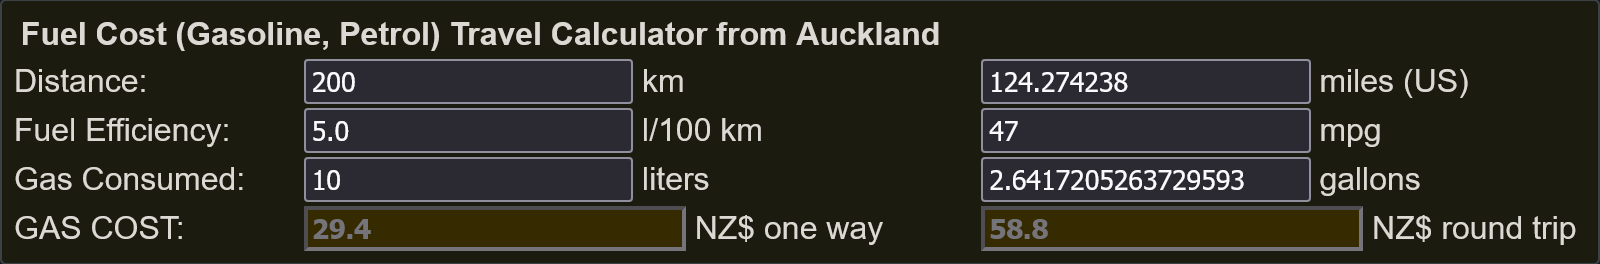

In [ ]:
'''
 - Using GitHub actions as a free and serverless computing power to run code on a schedule
 -> CI/CD pipeline
'''

#Introduction
Data scientist role is to turn:
* Data > Insights > Recommadation > Making Impact on Business




#1. BUSINESSES UNDERSTANDING

"How does this model or solution directly address our core business objectives?"

In [ ]:
# fuel now or later?
# make decision either to fuel now or later based on tank level and forecasted gas price and historical consumption?
# the  goal is the anticipate the price shocks and optimize fuel-cost purchase


#2. DATA PREPARATION

"Have we thoroughly cleaned and preprocessed our data to ensure it's of high quality?"

"Are we aware of any anomalies in our data that could impact model performance?"


##Work with real data

 - Streaming Data

 - Real time, user produced Data

 - Data updated frequently

##Work with modern technologies
	@Work with APIs
	  - Learn use, configure and setup APIs (Tokens)
	  - Learn use libraries to make API calls
      - Work with Data structures (JSON, Dictionaries...)
	  -> Collect/Retrieve Data
	@Databases in the cloud
	  - Store (pre/processed) Data in DB
	  - Learn use Cloud services (AWS, GC...)


In [3]:
# load data
data = pd.read_excel('https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMR_PTE_NUS_DPGw.xls', sheet_name='Data 1', skiprows=2)
data.head()

,Date,Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)
0,1990-08-20,1.191
1,1990-08-27,1.245
2,1990-09-03,1.242
3,1990-09-10,1.252
4,1990-09-17,1.266


In [4]:
data.tail()

,Date,Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)
1769,2024-07-15,3.496
1770,2024-07-22,3.471
1771,2024-07-29,3.484
1772,2024-08-05,3.448
1773,2024-08-12,3.414


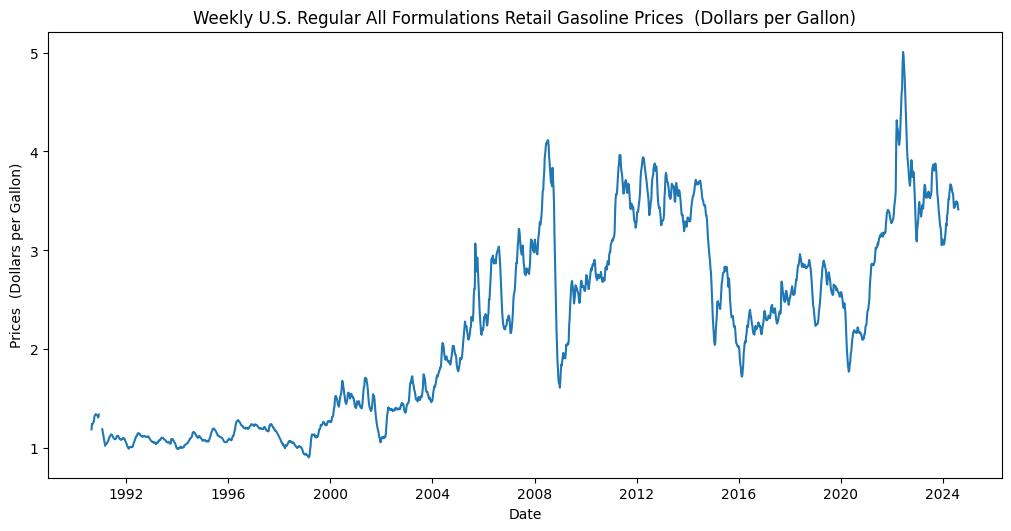

In [7]:
# plot the prices vs Dates
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Date', ascending=True)

plt.title('Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)')
plt.xlabel('Date')
plt.ylabel('Prices  (Dollars per Gallon)')

plt.plot(df_sorted['Date'],
         df_sorted['Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)'])

#3. FEATURE ENGINEERING

"Have we Build super strong features using transformations and Machine learning methods for dimensionality Reduction?"


In [ ]:
'''
Foundational models, like Chronos, doesnt require feature engieering
'''

#4. MODELING

"Have we compared different models supervised unsupervised or semi supervised?"

"Have we used AutoML?"

In [ ]:
# https://auto.gluon.ai/0.7.0/tutorials/timeseries/forecasting-indepth.html#what-is-probabilistic-time-series-forecasting

In [ ]:
# experimenting with chronos
# https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html
# https://github.com/amazon-science/chronos-forecasting

##Building Models
	@Start with Kaggle thought process
	@Understanding decision making choices
	@Questions to Answer:
	  - Why did you pick your model?
	  -> What are you trying to accomplish with this model that you couldn't do with another model.
	  - How did you clean your Data?
        - What type of validation tests did you perform on the Data to prepare it for the model?
	  - Tell me about the assumption of your model?
	  -> How did you validate these assumption?
	  - How did you optimize your model?
	  -> What are the trade-off decision that you've made?
	  - How did you implement your test/control?
	  - Tell me about how the underlying math in the model works?
	  - Model perfomance?
	@Goal> Thought Process and how the decision is made

## AutoGluon with minimal config

In [8]:
# formating data frame according to AutoGluon specs
df = data.copy()

df['item_id'] = 'Gas'

df.rename(columns={'Date':'timestamp',
                   'Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)':'target'},
          inplace=True)

df.head()

,timestamp,target,item_id
0,1990-08-20,1.191,Gas
1,1990-08-27,1.245,Gas
2,1990-09-03,1.242,Gas
3,1990-09-10,1.252,Gas
4,1990-09-17,1.266,Gas


In [19]:
# loading formated data
train_data = TimeSeriesDataFrame.from_data_frame(
    df[:-52],
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

target
item_id timestamp         
Gas     1990-08-20   1.191
        1990-08-27   1.245
        1990-09-03   1.242
        1990-09-10   1.252
        1990-09-17   1.266

In [20]:
predictor = TimeSeriesPredictor(
    prediction_length=52,
    path="us_gas",
    target="target",
    eval_metric="sMAPE",
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'us_gas'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       9.07 GB / 12.67 GB (71.6%)
Disk Space Avail:   42.65 GB / 78.19 GB (54.5%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': SMAPE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 52,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'W-MON'
Provided train_data has 1722 rows (NaN fraction=0.3%)

In [21]:
predictions = predictor.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [22]:
predictions

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
Gas     2023-08-21  3.757070  3.591120  3.627401  3.693987  3.753872   
        2023-08-28  3.782240  3.617931  3.650888  3.715169  3.772219   
        2023-09-04  3.797064  3.627432  3.662144  3.723792  3.781230   
        2023-09-11  3.793120  3.619892  3.655094  3.715412  3.774521   
        2023-09-18  3.784080  3.606645  3.643354  3.704502  3.763899   
        2023-09-25  3.764807  3.591513  3.625217  3.686219  3.741764   
        2023-10-02  3.756117  3.574295  3.613300  3.675388  3.729453   
        2023-10-09  3.736118  3.544716  3.588772  3.652662  3.706322   
        2023-10-16  3.710393  3.508675  3.556578  3.623448  3.678323   
        2023-10-23  3.683273  3.472092  3.522091  3.593164  3.650232   
        2023-10-30  3.654465  3.445835  3.496557  3.564628  3.619063   
        2023-11-06  3.631851  3.414473  3.470798  3.539859  3.594739   
        2023-11-13  3.604325  3.375624  3.438503  3.509996  3.565914   
        2023-11-20  3.575467  3.334513  3.403889  3.479154  3.536372   
        2023-11-27  3.554908  3.313217  3.386240  3.459601  3.514186   
        2023-12-04  3.529808  3.273520  3.356854  3.431684  3.486844   
        2023-12-11  3.501946  3.228942  3.322846  3.400453  3.457040   
        2023-12-18  3.475235  3.184520  3.288378  3.370276  3.428847   
        2023-12-25  3.450507  3.141096  3.254084  3.341857  3.402943   
        2024-01-01  3.650180  3.379159  3.482510  3.550302  3.593456   
        2024-01-08  3.657773  3.378411  3.484300  3.553716  3.597976   
        2024-01-15  3.667778  3.379096  3.488383  3.559583  3.606155   
        2024-01-22  3.680590  3.385880  3.497242  3.570216  3.618419   
        2024-01-29  3.676326  3.381191  3.489428  3.562472  3.611639   
        2024-02-05  3.685468  3.386712  3.497971  3.569774  3.619513   
        2024-02-12  3.692509  3.387758  3.502486  3.574376  3.625249   
        2024-02-19  3.701010  3.392290  3.509058  3.581671  3.633323   
        2024-02-26  3.699708  3.392728  3.505837  3.578432  3.630552   
        2024-03-04  3.709920  3.397352  3.514041  3.586027  3.639115   
        2024-03-11  3.723823  3.408755  3.527505  3.598800  3.652363   
        2024-03-18  3.729612  3.410120  3.530979  3.603103  3.657665   
        2024-03-25  3.737799  3.413189  3.535607  3.609825  3.665727   
        2024-04-01  3.739287  3.419265  3.538302  3.609550  3.665140   
        2024-04-08  3.751289  3.427701  3.549447  3.619918  3.676286   
        2024-04-15  3.758076  3.429071  3.553653  3.624648  3.682368   
        2024-04-22  3.765172  3.430755  3.557478  3.630065  3.689291   
        2024-04-29  3.763344  3.432282  3.556241  3.626912  3.685857   
        2024-05-06  3.775032  3.438882  3.566302  3.636291  3.696429   
        2024-05-13  3.782589  3.440912  3.571570  3.641661  3.703285   
        2024-05-20  3.792778  3.444412  3.578083  3.649577  3.713103   
        2024-05-27  3.792021  3.446694  3.577877  3.648243  3.711204   
        2024-06-03  3.807370  3.456638  3.591701  3.661169  3.725403   
        2024-06-10  3.824367  3.467063  3.606174  3.675508  3.741497   
        2024-06-17  3.840492  3.476093  3.618881  3.689139  3.757212   
        2024-06-24  3.852337  3.479298  3.625614  3.698273  3.768937   
        2024-07-01  3.858514  3.489398  3.634722  3.704144  3.773297   
        2024-07-08  3.877324  3.502184  3.651658  3.720700  3.791466   
        2024-07-15  3.895115  3.512148  3.665817  3.735822  3.808891   
        2024-07-22  3.908447  3.516719  3.674086  3.746519  3.822280   
        2024-07-29  3.910706  3.523302  3.679141  3.749622  3.823321   
        2024-08-05  3.927255  3.534023  3.693848  3.764145  3.839350   
        2024-08-12  3.941775  3.541590  3.705245  3.776445  3.853704   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                               

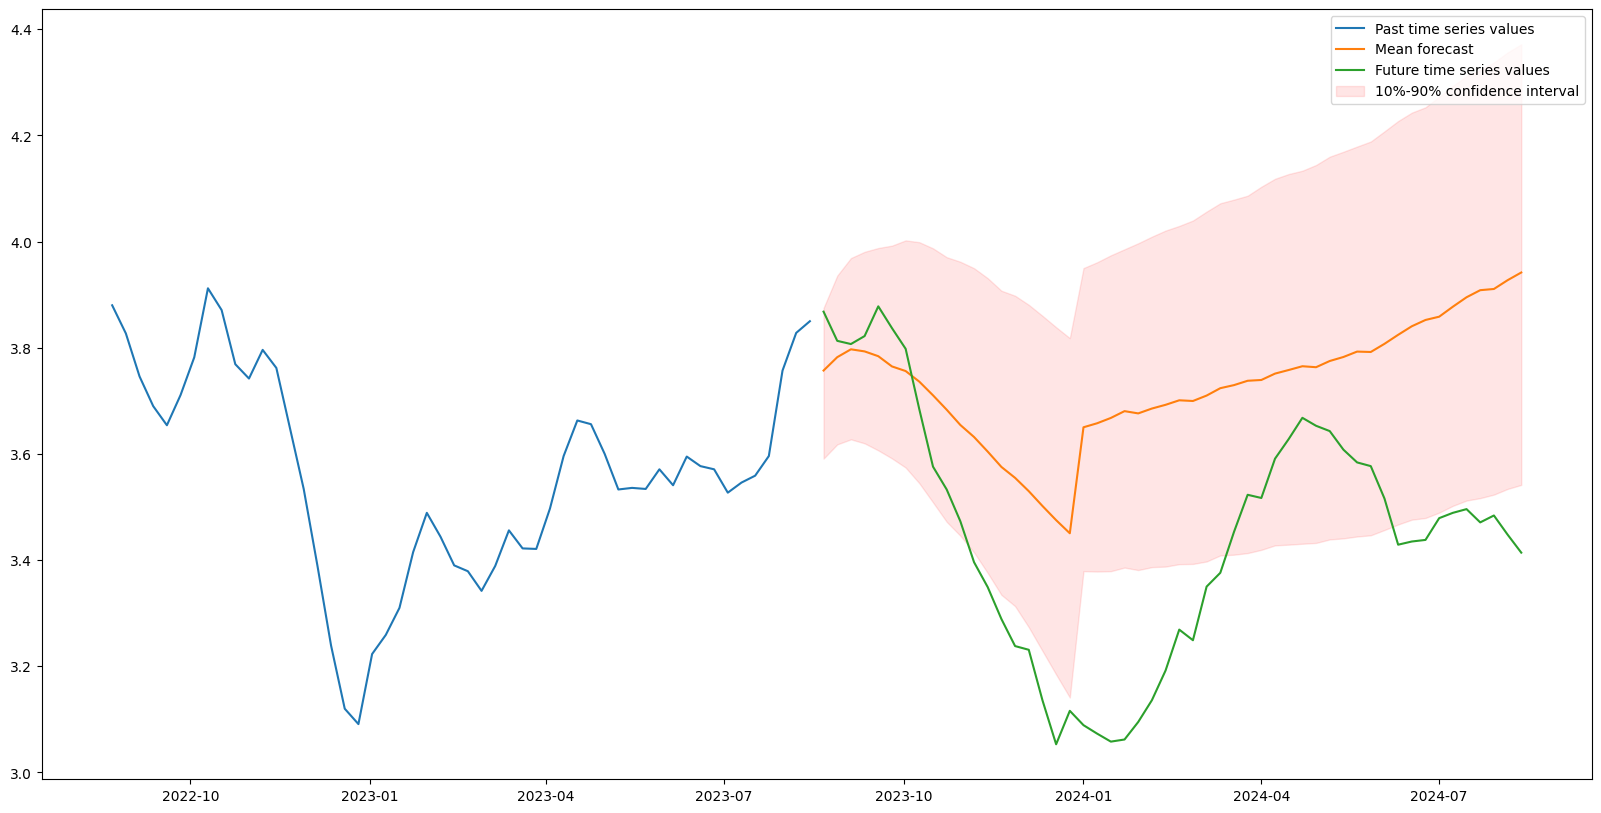

In [24]:
test_data = TimeSeriesDataFrame.from_data_frame(
    df[-52:],
    id_column="item_id",
    timestamp_column="timestamp"
)

plt.figure(figsize=(20, 10))

item_id = "Gas"
y_past = train_data.loc[item_id]["target"][-52:]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][-52:]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

#5. MODEL PERFORMANCE

"Have we explored various models and performed hyperparameter tuning to ensure optimal performance?"

"Do we have a benchmark or baseline model performance for comparison?"

In [25]:
# Prediction vs Actual values (training set)
predictions = predictor.predict(train_data)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
Gas     2023-08-21  3.757070  3.591120  3.627401  3.693987  3.753872   
        2023-08-28  3.782240  3.617931  3.650888  3.715169  3.772219   
        2023-09-04  3.797064  3.627432  3.662144  3.723792  3.781230   
        2023-09-11  3.793120  3.619892  3.655094  3.715412  3.774521   
        2023-09-18  3.784080  3.606645  3.643354  3.704502  3.763899   
        2023-09-25  3.764807  3.591513  3.625217  3.686219  3.741764   
        2023-10-02  3.756117  3.574295  3.613300  3.675388  3.729453   
        2023-10-09  3.736118  3.544716  3.588772  3.652662  3.706322   
        2023-10-16  3.710393  3.508675  3.556578  3.623448  3.678323   
        2023-10-23  3.683273  3.472092  3.522091  3.593164  3.650232   
        2023-10-30  3.654465  3.445835  3.496557  3.564628  3.619063   
        2023-11-06  3.631851  3.414473  3.470798  3.539859  3.594739   
        2023-11-13  3.604325  3.375624  3.438503  3.509996  3.565914   
        2023-11-20  3.575467  3.334513  3.403889  3.479154  3.536372   
        2023-11-27  3.554908  3.313217  3.386240  3.459601  3.514186   
        2023-12-04  3.529808  3.273520  3.356854  3.431684  3.486844   
        2023-12-11  3.501946  3.228942  3.322846  3.400453  3.457040   
        2023-12-18  3.475235  3.184520  3.288378  3.370276  3.428847   
        2023-12-25  3.450507  3.141096  3.254084  3.341857  3.402943   
        2024-01-01  3.650180  3.379159  3.482510  3.550302  3.593456   
        2024-01-08  3.657773  3.378411  3.484300  3.553716  3.597976   
        2024-01-15  3.667778  3.379096  3.488383  3.559583  3.606155   
        2024-01-22  3.680590  3.385880  3.497242  3.570216  3.618419   
        2024-01-29  3.676326  3.381191  3.489428  3.562472  3.611639   
        2024-02-05  3.685468  3.386712  3.497971  3.569774  3.619513   
        2024-02-12  3.692509  3.387758  3.502486  3.574376  3.625249   
        2024-02-19  3.701010  3.392290  3.509058  3.581671  3.633323   
        2024-02-26  3.699708  3.392728  3.505837  3.578432  3.630552   
        2024-03-04  3.709920  3.397352  3.514041  3.586027  3.639115   
        2024-03-11  3.723823  3.408755  3.527505  3.598800  3.652363   
        2024-03-18  3.729612  3.410120  3.530979  3.603103  3.657665   
        2024-03-25  3.737799  3.413189  3.535607  3.609825  3.665727   
        2024-04-01  3.739287  3.419265  3.538302  3.609550  3.665140   
        2024-04-08  3.751289  3.427701  3.549447  3.619918  3.676286   
        2024-04-15  3.758076  3.429071  3.553653  3.624648  3.682368   
        2024-04-22  3.765172  3.430755  3.557478  3.630065  3.689291   
        2024-04-29  3.763344  3.432282  3.556241  3.626912  3.685857   
        2024-05-06  3.775032  3.438882  3.566302  3.636291  3.696429   
        2024-05-13  3.782589  3.440912  3.571570  3.641661  3.703285   
        2024-05-20  3.792778  3.444412  3.578083  3.649577  3.713103   
        2024-05-27  3.792021  3.446694  3.577877  3.648243  3.711204   
        2024-06-03  3.807370  3.456638  3.591701  3.661169  3.725403   
        2024-06-10  3.824367  3.467063  3.606174  3.675508  3.741497   
        2024-06-17  3.840492  3.476093  3.618881  3.689139  3.757212   
        2024-06-24  3.852337  3.479298  3.625614  3.698273  3.768937   
        2024-07-01  3.858514  3.489398  3.634722  3.704144  3.773297   
        2024-07-08  3.877324  3.502184  3.651658  3.720700  3.791466   
        2024-07-15  3.895115  3.512148  3.665817  3.735822  3.808891   
        2024-07-22  3.908447  3.516719  3.674086  3.746519  3.822280   
        2024-07-29  3.910706  3.523302  3.679141  3.749622  3.823321   
        2024-08-05  3.927255  3.534023  3.693848  3.764145  3.839350   
        2024-08-12  3.941775  3.541590  3.705245  3.776445  3.853704   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                               

In [26]:
# Model leaderboard (training set)
predictor.leaderboard(train_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,PatchTST,-0.048146,-0.101885,0.049720,0.019940,54.590781,12
1,WeightedEnsemble,-0.066747,-0.090610,0.728091,0.975478,4.785170,13
2,Chronos[base],-0.089879,-0.121035,3.258555,2.956032,3.272897,9
3,TemporalFusionTransformer,-0.090055,-0.103242,0.083647,0.025638,135.808914,10
4,AutoARIMA,-0.091758,-0.202283,0.589268,0.559451,0.869665,8
5,DynamicOptimizedTheta,-0.098649,-0.138555,0.186798,0.326601,0.358283,6
6,SeasonalNaive,-0.101634,-0.137462,0.017934,0.013454,0.053586,1
7,AutoETS,-0.101637,-0.137464,0.151976,0.244112,0.233440,7
8,RecursiveTabular,-0.123757,-0.116024,0.590311,0.929899,10.859577,2
9,CrostonSBA,-0.144314,-0.207473,0.026876,0.024927,0.090396,4


#6. MODEL EVALUATION

"Are we evaluating our model on a diverse set of metrics to understand its strengths and weaknesses fully?"

"Have we used techniques like cross-validation to ensure our model generalizes well to unseen data?"

In [27]:
# Model leaderboard (test set)
test_data = TimeSeriesDataFrame.from_data_frame(
    df[-53:],
    id_column="item_id",
    timestamp_column="timestamp"
)

predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,PatchTST,-0.073393,-0.101885,0.042180,0.019940,54.590781,12
1,CrostonSBA,-0.073578,-0.207473,0.014027,0.024927,0.090396,4
2,Chronos[base],-0.097671,-0.121035,2.877303,2.956032,3.272897,9
3,WeightedEnsemble,-0.108034,-0.090610,0.155786,0.975478,4.785170,13
4,TemporalFusionTransformer,-0.110099,-0.103242,0.077782,0.025638,135.808914,10
5,SeasonalNaive,-0.112257,-0.137462,0.016425,0.013454,0.053586,1
6,RecursiveTabular,-0.112257,-0.116024,0.032342,0.929899,10.859577,2
7,NPTS,-0.112257,-0.456598,0.032015,0.930807,0.959886,5
8,DynamicOptimizedTheta,-0.112257,-0.138555,0.017972,0.326601,0.358283,6
9,DirectTabular,-0.112257,-0.228947,0.033149,0.097510,3.802001,3


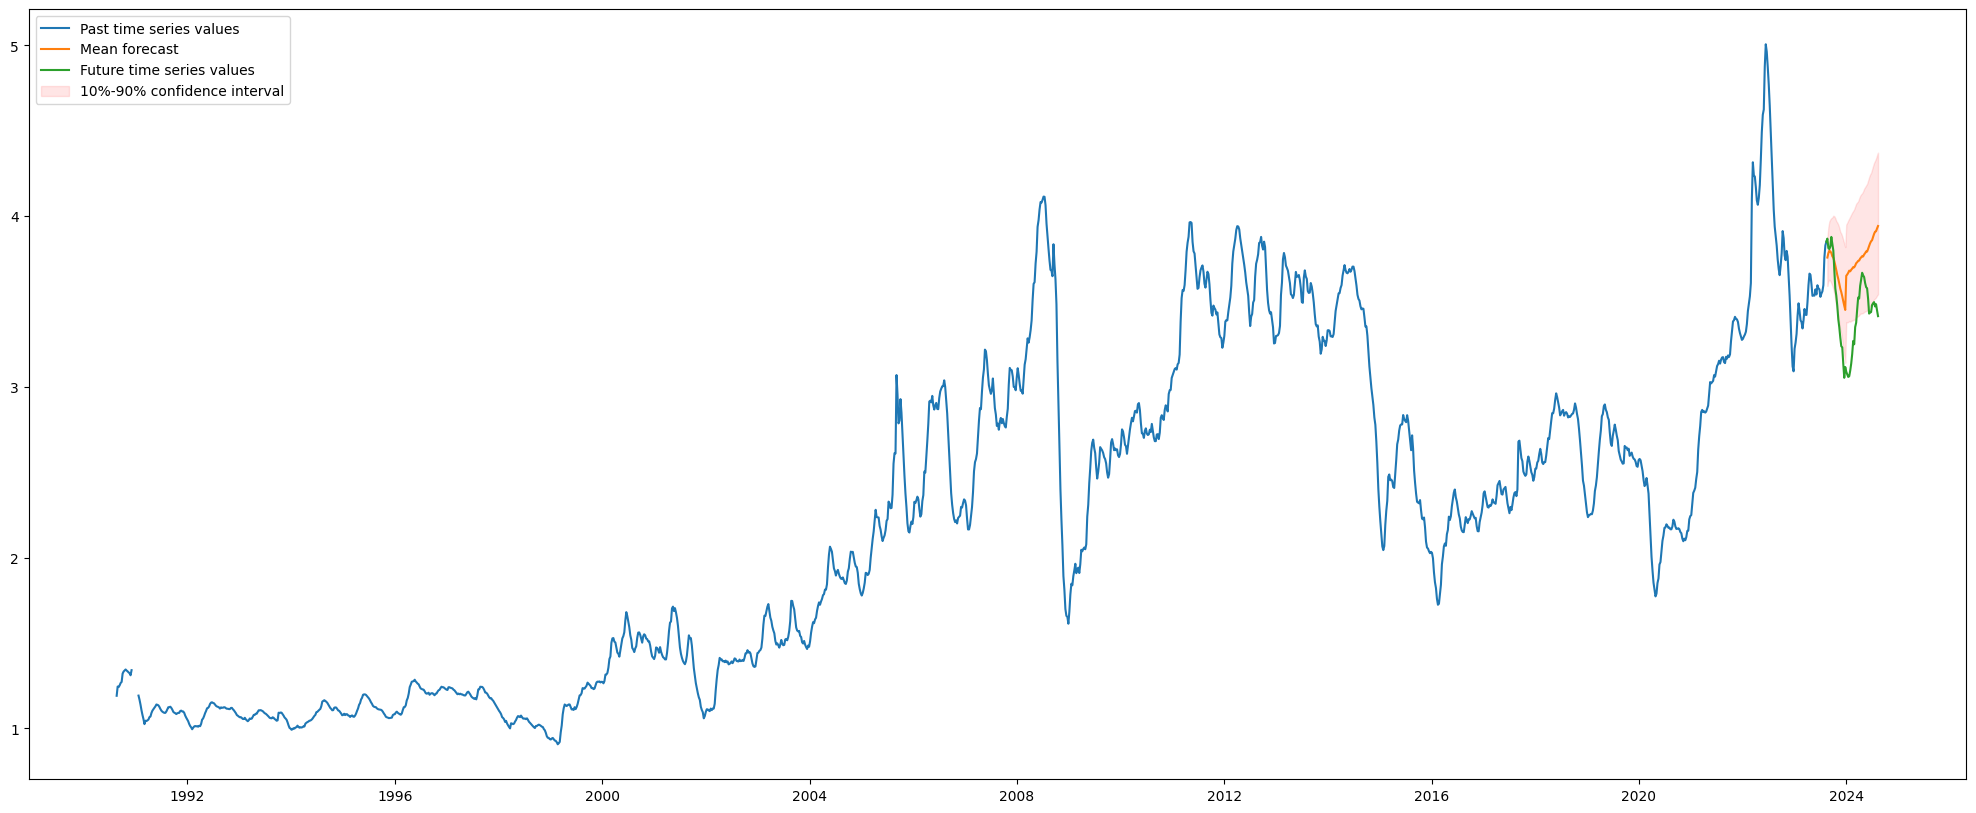

In [28]:
plt.figure(figsize=(25, 10))

item_id = "Gas"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"] #[-200:]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

#7. MODEL FINE TUNNING

"Have we used Hyperparameter tunning with Bayesian Search?"


## AutoGluon with manual&hyper param config



In [30]:
df

,timestamp,target,item_id
0,1990-08-20,1.191,Gas
1,1990-08-27,1.245,Gas
2,1990-09-03,1.242,Gas
3,1990-09-10,1.252,Gas
4,1990-09-17,1.266,Gas
...,...,...,...
1769,2024-07-15,3.496,Gas
1770,2024-07-22,3.471,Gas
1771,2024-07-29,3.484,Gas
1772,2024-08-05,3.448,Gas


In [47]:
# Adding variables
## past_covariates
from statsmodels.tsa.ar_model import ar_select_order
df_cleaned = df.copy().dropna()


In [49]:
df_cleaned.set_index('timestamp', inplace=True)
df_cleaned.head()

,target,item_id
timestamp,,
1990-08-20,1.191,Gas
1990-08-27,1.245,Gas
1990-09-03,1.242,Gas
1990-09-10,1.252,Gas
1990-09-17,1.266,Gas


In [77]:
df_cleaned = df.copy()
# df_cleaned = df_cleaned.asfreq('W')

mod = ar_select_order(df_cleaned.target,
                      trend='ct',
                      glob=True,
                      missing='drop',
                      # seasonal=True,
                      maxlag=15)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [64]:
mod.ar_lags

[1, 2, 4]

In [ ]:
predictor_tuned = TimeSeriesPredictor(
    prediction_length=52,
    path="us_gas",
    target="target",
    eval_metric="sMAPE",
)

predictor_tuned.fit(
    train_data,
    hyperparameters={
        "NaiveModel": {},
        "LGBModel": {},
        "Chronos[large]": {
            "model_path": "tiny",
            "batch_size": [8, 16, 32],
            "device": "cuda",
        }
    },
    hyperparameter_tune_kwargs="auto",
    enable_ensemble=True,
    time_limit=600,
)

In [ ]:
# Performance & Evals of Model war (Chrnons vs LGBM)

Model not specified in predict, will default to the model with the best validation score: Chronos[tiny]


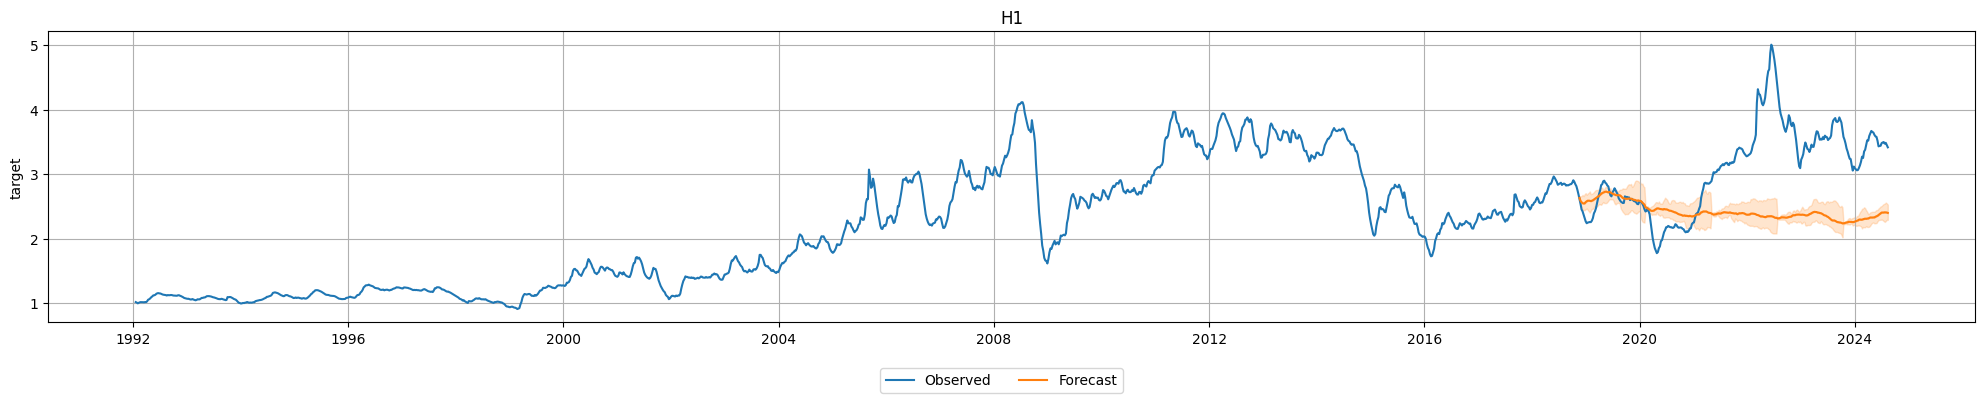

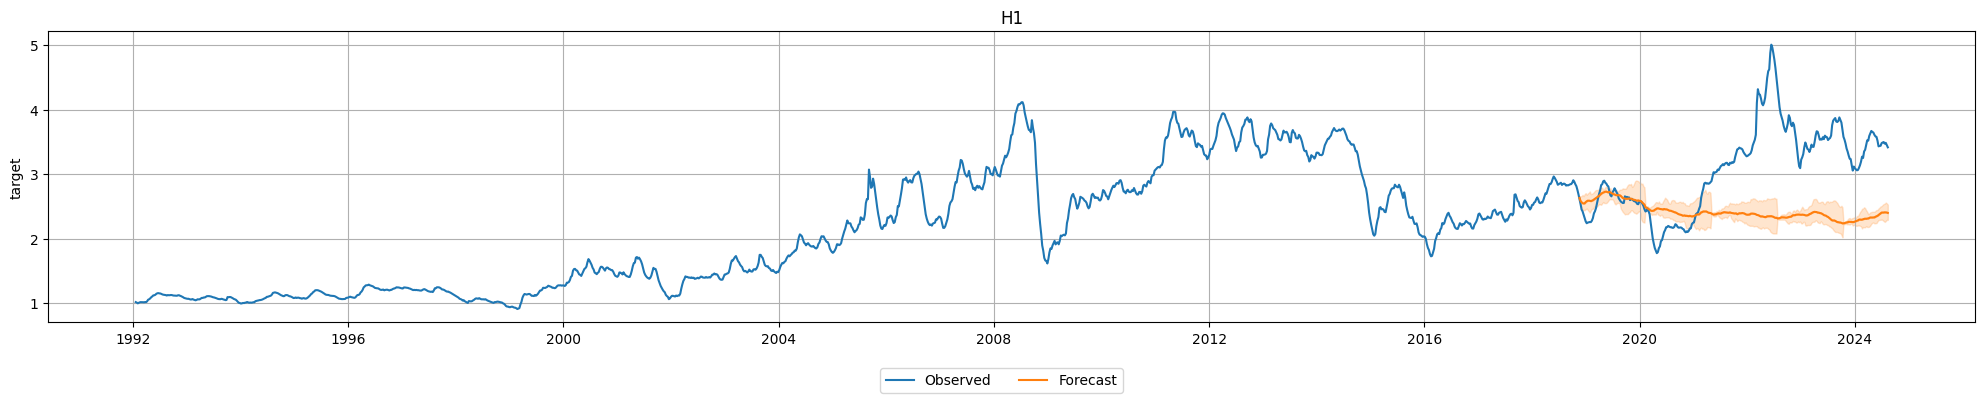

In [49]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=c_data,
    predictions=predictions,
    item_ids=["H1"],
    max_history_length=1700,
)

#8. DEPLOYMENT

"Is our model designed with deployment in mind, considering integration and operational needs?"

##Making an impact / Getting validation
	@Share code with DS community
	  - Git repo...
	@Publish finding
	  - Create visualization
	  -> Article/Blog...
	@Turn it into useful App
	  - Learn Application framework
	  - django, Flask...
	  - Deploy an application in the cloud
	  -> AWS, GC...
	  - Example
	  -> Interactive DashBoard, API...


#9. AI EXPLAINABILITY

"Can we explain how our model makes decisions in a way that's understandable to non-technical stakeholders?"

#10. MODEL MONITORING

"Are we continuously monitoring model performance and seeking opportunities for improvement?"

#11. AI FAIRNESS

"Have we considered the ethical implications of our data sources and modeling techniques?"

"Have we assessed our model for potential biases against certain groups or individuals?"

"What steps have we taken to mitigate any identified biases in our model?"

# 12. REFERENCES

[Fuel Cost (Gasoline, Petrol) Travel Calculator](https://www.numbeo.com/gas-prices/in/Albany)

[US Gasoline and Diesel Fuel Update](https://www.eia.gov/petroleum/gasdiesel/)

[Chronos: Learning the Language of Time Series](https://github.com/amazon-science/chronos-forecasting)

[Adapting language model architectures for time series forecasting](https://www.amazon.science/blog/adapting-language-model-architectures-for-time-series-forecasting)

